<a href="https://colab.research.google.com/github/ronaldoaf/999.079_AT_MUDA_STATE_JOB/blob/master/GRU_FOREX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None


import torch
from torch import nn
from torch import optim

from sklearn.model_selection import train_test_split


import time



In [ ]:

#Carrega dos dados OHLCV
df= pd.read_csv('https://aposte.me/files/XAUUSDm_M30.csv', delimiter="\t")


df['Datetime']=pd.to_datetime(df['DATE'] + ' '+df['TIME'], format='%Y.%m.%d %H:%M')

df=df['Datetime,OPEN,HIGH,LOW,CLOSE,TICKVOL'.split(",")]
df=df.set_index('Datetime')

#Diferença do log do CLOSE e TICKVOL
df['C']=np.log(df.CLOSE) - np.log( df.CLOSE.shift(1) )
df['V']=np.log(df.TICKVOL) - np.log( df.TICKVOL.shift(1) )

df

,OPEN,HIGH,LOW,CLOSE,TICKVOL,C,V
Datetime,,,,,,,
2017-05-02 11:00:00,1255.628,1255.916,1254.940,1255.023,1316,NaN,NaN
2017-05-02 11:30:00,1255.023,1255.994,1255.023,1255.686,1371,0.000528,0.040944
2017-05-02 12:00:00,1255.704,1255.965,1255.274,1255.375,1237,-0.000248,-0.102851
2017-05-02 12:30:00,1255.373,1255.946,1254.712,1254.731,1552,-0.000513,0.226855
2017-05-02 13:00:00,1254.741,1254.861,1252.584,1252.813,2299,-0.001530,0.392930
...,...,...,...,...,...,...,...
2023-05-22 08:30:00,1975.976,1980.731,1975.328,1980.684,1976,0.002381,0.006601
2023-05-22 09:00:00,1980.681,1982.530,1979.999,1980.524,2041,-0.000081,0.032365
2023-05-22 09:30:00,1980.535,1981.870,1979.216,1979.633,1778,-0.000450,-0.137951


In [ ]:
#Cria um novo DataFrame com os últimos N  "Cs" e "Vs" 
N=50
cols={}
for i in range(N,0,-1):
    for e in ['C','V']:
        cols[e + str(i)]=df[e].shift(i)


df1=pd.DataFrame(cols).dropna()

df1

,C50,V50,C49,V49,C48,V48,C47,V47,C46,V46,...,C5,V5,C4,V4,C3,V3,C2,V2,C1,V1
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-05-03 13:30:00,0.000528,0.040944,-0.000248,-0.102851,-0.000513,0.226855,-0.001530,0.392930,0.000062,-0.003922,...,-0.000358,-0.297225,0.000250,0.079971,-0.000003,-0.150702,0.000035,0.304853,-0.000368,0.517612
2017-05-03 14:00:00,-0.000248,-0.102851,-0.000513,0.226855,-0.001530,0.392930,0.000062,-0.003922,0.000361,0.038969,...,0.000250,0.079971,-0.000003,-0.150702,0.000035,0.304853,-0.000368,0.517612,-0.000392,0.237943
2017-05-03 14:30:00,-0.000513,0.226855,-0.001530,0.392930,0.000062,-0.003922,0.000361,0.038969,0.001429,0.091063,...,-0.000003,-0.150702,0.000035,0.304853,-0.000368,0.517612,-0.000392,0.237943,-0.000650,-0.165633
2017-05-03 15:00:00,-0.001530,0.392930,0.000062,-0.003922,0.000361,0.038969,0.001429,0.091063,-0.000664,-0.009245,...,0.000035,0.304853,-0.000368,0.517612,-0.000392,0.237943,-0.000650,-0.165633,-0.000398,0.050801
2017-05-03 15:30:00,0.000062,-0.003922,0.000361,0.038969,0.001429,0.091063,-0.000664,-0.009245,0.000320,-0.109065,...,-0.000368,0.517612,-0.000392,0.237943,-0.000650,-0.165633,-0.000398,0.050801,-0.003705,0.141930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22 08:30:00,-0.002097,-0.243851,0.000701,0.015133,0.000550,-0.021506,-0.000354,-0.145662,-0.000775,-0.058900,...,0.001146,0.219137,0.000480,-0.280533,-0.000686,0.102235,0.000948,-0.081200,-0.000418,-0.140006
2023-05-22 09:00:00,0.000701,0.015133,0.000550,-0.021506,-0.000354,-0.145662,-0.000775,-0.058900,0.000183,-0.092542,...,0.000480,-0.280533,-0.000686,0.102235,0.000948,-0.081200,-0.000418,-0.140006,0.002381,0.006601
2023-05-22 09:30:00,0.000550,-0.021506,-0.000354,-0.145662,-0.000775,-0.058900,0.000183,-0.092542,0.001369,0.209395,...,-0.000686,0.102235,0.000948,-0.081200,-0.000418,-0.140006,0.002381,0.006601,-0.000081,0.032365


In [ ]:
#Carrega CSV com Lucro ou Prejuizo, de um operação de compra e venda
#Cada operações tem esses parametros TakeProfit=2ATRs e StopLoss=1ATR
df2=pd.read_csv('https://aposte.me/files/XAUUSD_30M_2TP_1SL.csv').set_index('open_time')

df2.index=pd.to_datetime(df2.index)

df2

,atr,buy_PL,sell_PL
open_time,,,
2017-05-01 00:00:00,0.998000,-10.14,19.96
2017-05-01 00:30:00,1.024429,-10.29,20.51
2017-05-01 01:00:00,1.001286,-10.05,20.19
2017-05-01 01:30:00,1.005000,-10.18,20.49
2017-05-01 02:00:00,1.154357,-11.81,23.14
...,...,...,...
2022-04-29 18:30:00,5.030786,-50.49,100.75
2022-04-29 19:00:00,4.717071,-47.35,94.47
2022-04-29 19:30:00,4.814929,-48.25,36.52


In [ ]:
#Faz o merge dos DataFames anteriores
df3=df1.merge(df2[['buy_PL','sell_PL']], left_index=True, right_index=True)

df3

,C50,V50,C49,V49,C48,V48,C47,V47,C46,V46,...,C4,V4,C3,V3,C2,V2,C1,V1,buy_PL,sell_PL
2017-05-03 13:30:00,0.000528,0.040944,-0.000248,-0.102851,-0.000513,0.226855,-0.001530,0.392930,0.000062,-0.003922,...,0.000250,0.079971,-0.000003,-0.150702,0.000035,0.304853,-0.000368,0.517612,-10.91,21.79
2017-05-03 14:00:00,-0.000248,-0.102851,-0.000513,0.226855,-0.001530,0.392930,0.000062,-0.003922,0.000361,0.038969,...,-0.000003,-0.150702,0.000035,0.304853,-0.000368,0.517612,-0.000392,0.237943,-11.76,23.73
2017-05-03 14:30:00,-0.000513,0.226855,-0.001530,0.392930,0.000062,-0.003922,0.000361,0.038969,0.001429,0.091063,...,0.000035,0.304853,-0.000368,0.517612,-0.000392,0.237943,-0.000650,-0.165633,-12.57,25.22
2017-05-03 15:00:00,-0.001530,0.392930,0.000062,-0.003922,0.000361,0.038969,0.001429,0.091063,-0.000664,-0.009245,...,-0.000368,0.517612,-0.000392,0.237943,-0.000650,-0.165633,-0.000398,0.050801,-13.10,26.53
2017-05-03 15:30:00,0.000062,-0.003922,0.000361,0.038969,0.001429,0.091063,-0.000664,-0.009245,0.000320,-0.109065,...,-0.000392,0.237943,-0.000650,-0.165633,-0.000398,0.050801,-0.003705,0.141930,33.65,-16.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 18:30:00,0.001416,0.091556,0.000886,0.157765,-0.000734,-0.223667,0.001363,-0.186172,0.000572,-0.005803,...,-0.000341,-0.106519,0.001021,0.108782,-0.000123,-0.134307,0.000596,0.082823,-50.49,100.75
2022-04-29 19:00:00,0.000886,0.157765,-0.000734,-0.223667,0.001363,-0.186172,0.000572,-0.005803,0.001850,0.067510,...,0.001021,0.108782,-0.000123,-0.134307,0.000596,0.082823,-0.001545,0.032314,-47.35,94.47
2022-04-29 19:30:00,-0.000734,-0.223667,0.001363,-0.186172,0.000572,-0.005803,0.001850,0.067510,-0.000003,-0.082973,...,-0.000123,-0.134307,0.000596,0.082823,-0.001545,0.032314,-0.003963,0.343361,-48.25,36.52
2022-04-29 20:00:00,0.001363,-0.186172,0.000572,-0.005803,0.001850,0.067510,-0.000003,-0.082973,-0.000134,-0.429668,...,0.000596,0.082823,-0.001545,0.032314,-0.003963,0.343361,-0.002108,0.283095,-0.13,-3.87


Máximo PL:  tensor(55.8459)
min: 0.00  pl_total: -10.17
min: 0.01  pl_total: 3.15
min: 0.02  pl_total: 13.34
min: 0.03  pl_total: 25.77
min: 0.04  pl_total: 33.17
min: 0.05  pl_total: 28.66
min: 0.06  pl_total: 35.89
min: 0.07  pl_total: 39.71
min: 0.08  pl_total: 39.05
min: 0.09  pl_total: 49.43
min: 0.10  pl_total: 47.07
min: 0.11  pl_total: 44.53
min: 0.12  pl_total: 46.74
min: 0.13  pl_total: 50.36
min: 0.14  pl_total: 51.21
min: 0.15  pl_total: 49.37
min: 0.16  pl_total: 49.43
min: 0.17  pl_total: 50.43
min: 0.18  pl_total: 51.10
min: 0.19  pl_total: 49.37
min: 0.20  pl_total: 50.59
min: 0.21  pl_total: 55.85
min: 0.22  pl_total: 53.64
min: 0.23  pl_total: 50.23
min: 0.24  pl_total: 53.07
min: 0.25  pl_total: 51.92
min: 0.26  pl_total: 53.54
min: 0.27  pl_total: 55.58
min: 0.28  pl_total: 53.72
min: 0.29  pl_total: 52.64
min: 0.30  pl_total: 50.92
min: 0.31  pl_total: 51.51
min: 0.32  pl_total: 54.13
min: 0.33  pl_total: 54.50
min: 0.34  pl_total: 46.54
min: 0.35  pl_total: 48.49


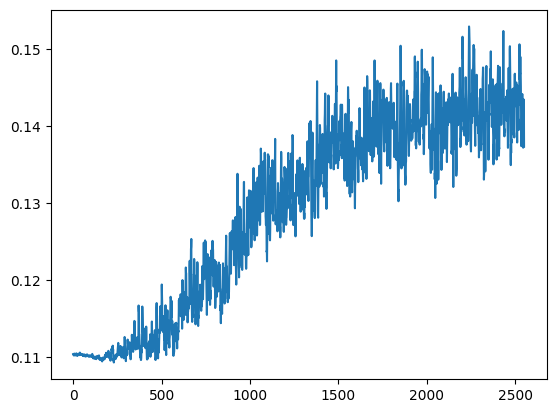

In [ ]:
inicio=time.time()


df_train, df_test = train_test_split(df3, test_size=0.1, shuffle=False)



#Coloca em escala de -1 e 1,  99.5% ddos dados
corte=99.5

max_diff=np.percentile([abs(df_train.C1)], corte )
max_vol=np.percentile([abs(df_train.V1)], corte )

max_PL=np.percentile([abs(df_train.buy_PL),abs(df_train.sell_PL)], corte )

df_train[df3.columns[df3.columns.str.contains('C')]]/=max_diff
df_test[df3.columns[df3.columns.str.contains('C')]]/=max_diff
df_train[df3.columns[df3.columns.str.contains('V')]]/=max_vol
df_test[df3.columns[df3.columns.str.contains('V')]]/=max_vol

df_train[df3.columns[-2:]]/=max_PL
df_test[df3.columns[-2:]]/=max_PL




#Transforma os DataFrames em Tensors
X_train=torch.Tensor(df_train.iloc[:,:-2].values)
Y_train=torch.Tensor(df_train.iloc[:,-2:].values)

X_test=torch.Tensor(df_test.iloc[:,:-2].values)
Y_test=torch.Tensor(df_test.iloc[:,-2:].values )





#Define um classse para trabalhar com a camada GRU
class GRU(nn.Module):
    def __init__(self, n_features, hidden_dim, n_layers=1,dropout=0.1):
        super(GRU, self).__init__()
        self.n_features=n_features
        self.gru = nn.GRU(n_features, hidden_dim, n_layers, batch_first=True,dropout=dropout)

    def forward(self, x):
        x=x.view(x.size(0),x.size(1)//self.n_features,self.n_features )
        out, _ = self.gru(x)  
        return out[:, -1, :]  


#Define um classse para trabalhar com a camada LSTM
class LSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, n_layers=1,dropout=0.1):
        super(LSTM, self).__init__()
        self.n_features=n_features
        self.lstm = nn.LSTM(n_features, hidden_dim, n_layers, batch_first=True,dropout=dropout)

    def forward(self, x):
        x=x.view(x.size(0),x.size(1)//self.n_features,self.n_features )
        out, _ = self.lstm(x)  
        return out[:, -1, :] 




#===META PARAMETROS===========================================================

LR=0.01            #Learning Rate 
epochs = 100       #Número de interações 
batch_size=2000    #Tamanho da amostra que será carregada por vez 

n_features=2   #Número de features da entrada 2 (C e V)
hidden_dim=30  #Dimensão das camadas escondidas
n_layers=2     #Numeros de camadas ocultas do modelo
dropout=0.2    #Probabilidade de Dropout


model=nn.Sequential(
    GRU( n_features, hidden_dim, n_layers, dropout=0.2),
    nn.Dropout(p=dropout),
    nn.CELU(),
    nn.Dropout(p=dropout),
    nn.Linear(hidden_dim,2),
)




#Se tiver GPU disponivel usa a utiliza para acelerar o processo
if torch.cuda.is_available():
  X_train=X_train.cuda()
  X_test=X_test.cuda()
  Y_train=Y_train.cuda()
  Y_test=Y_test.cuda()
  model=model.cuda()





# Loss and optimizer
loss_func=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)




losses=[]
for _ in range(epochs):  
    permutation = torch.randperm(X_train.shape[0])
    for i in range(0,X_train.shape[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y= X_train[indices], Y_train[indices]
        
        optimizer.zero_grad() 
        y_pred = model(batch_x)
        loss = loss_func(y_pred, batch_y)
    
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            losses+=[float(loss_func(model(X_test), Y_test).item())]

#exibe o gráfico do loss da validação 
pd.Series(losses[int(epochs/2):]).plot.line()





#====LUCRATIVIDADE NA VALIDAÇÃO================

model.eval()

Y_pred=model(X_test)
maximo_pl=torch.Tensor([Y_test[Y_pred[:,0]>k*0.01][:,0].sum()+Y_test[Y_pred[:,1]>k*0.01][:,1].sum() for k in range(90)]).max() 

print('Máximo PL: ', maximo_pl)


dft=pd.DataFrame()
dft[['buy_pred','sell_pred']]=pd.DataFrame( model(X_test).cpu().detach().numpy() )
dft[['buy','sell']]=pd.DataFrame(Y_test.detach().cpu().numpy() )

for i in range(60):
    k=i*0.01
    pl_total= dft[dft.buy_pred>k].buy.sum()+dft[dft.sell_pred>k].sell.sum()
    print('min:',f'{k:.2f} ', 'pl_total:', f'{pl_total:.2f}' )


print('tempo gasto:', time.time()-inicio)

In [ ]:
#Salva o modelo treinando em arqivo 
torch.save(model,'model2')

#Rodamos a célula acima algumas vezes e salvamos como model0, model1, model2...


!ls model*

model0	model1	model2


In [ ]:
#Define um classe que gera um modelo dado uma lista modelos 
class AVERAGE(nn.Module):
    def __init__(self, model_list):
        super(AVERAGE, self).__init__()
        self.model_list=model_list

    def forward(self, x):
        sum=self.model_list[0](x)
        for m in self.model_list[1:]: sum+=m(x)
        return (sum/len(self.model_list))

#Carrega o modelos em lista de modelos
models=[torch.load(f'model{i}') for i in range(3) ]

#Define o modelo é media dos modelos
model=AVERAGE(models)

#Deixa em pode de teste
model.eval()

AVERAGE()

In [ ]:
#Verifica a lucatividade do modelo médio

dft=pd.DataFrame()

dft[['buy_pred','sell_pred']]=pd.DataFrame( model(X_test).cpu().detach().numpy() )
dft[['buy','sell']]=pd.DataFrame(Y_test.detach().cpu().numpy() )


for i in range(60):
    k=i*0.01
    pl_total= dft[dft.buy_pred>k].buy.sum()+dft[dft.sell_pred>k].sell.sum()
    print('min:',f'{k:.2f} ', 'pl_total:', f'{pl_total:.2f}' )


min: 0.00  pl_total: 23.77
min: 0.01  pl_total: 37.10
min: 0.02  pl_total: 37.27
min: 0.03  pl_total: 35.61
min: 0.04  pl_total: 33.11
min: 0.05  pl_total: 38.82
min: 0.06  pl_total: 41.75
min: 0.07  pl_total: 48.44
min: 0.08  pl_total: 51.84
min: 0.09  pl_total: 55.28
min: 0.10  pl_total: 62.96
min: 0.11  pl_total: 67.29
min: 0.12  pl_total: 62.57
min: 0.13  pl_total: 60.25
min: 0.14  pl_total: 57.83
min: 0.15  pl_total: 55.38
min: 0.16  pl_total: 59.52
min: 0.17  pl_total: 58.27
min: 0.18  pl_total: 52.34
min: 0.19  pl_total: 50.87
min: 0.20  pl_total: 50.18
min: 0.21  pl_total: 50.08
min: 0.22  pl_total: 47.30
min: 0.23  pl_total: 48.47
min: 0.24  pl_total: 51.73
min: 0.25  pl_total: 52.56
min: 0.26  pl_total: 49.40
min: 0.27  pl_total: 42.59
min: 0.28  pl_total: 38.55
min: 0.29  pl_total: 37.55
min: 0.30  pl_total: 33.68
min: 0.31  pl_total: 35.83
min: 0.32  pl_total: 33.73
min: 0.33  pl_total: 36.91
min: 0.34  pl_total: 33.60
min: 0.35  pl_total: 32.77
min: 0.36  pl_total: 32.85
m

In [ ]:
!pip install onnx

#Exporta o modelo no formato ONNX
torch.onnx.export(models[0],               # modelo que está sendo executado
                  X_test[:1],           # modelo de entrada (ou uma tupla se múltiplas entradas)
                  "XAUUSD_30M_GRU.onnx",     # nome do arquivo de saída
                  export_params=True,  # armazene os pesos treinados no arquivo de modelo
                  opset_version=12,    # versão ONNX
                  do_constant_folding=True)  # se deve executar a otimização constante de dobramento



#Modelo Médio não está sendo possível de exportar, por isso estou exportando só a um modelo da lista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 92.6 MB/s eta 0:00:00
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [ ]:
!ls  *.onnx

XAUUSD_30M_GRU.onnx
